In [1]:
# !pip install "tensorflow<2.11"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [3]:
# Connect ke GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
PATH_DATA = "data"

images = []
labels = []

for subfolder in os.listdir(PATH_DATA):
    
    subfolder_path = os.path.join(PATH_DATA, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
 
df = pd.DataFrame({'image': images, 'label': labels})

In [5]:
# All Augmentation
def augmentation():
    augmentation_img = tf.keras.preprocessing.image.ImageDataGenerator( 
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest' 
        ) 
    return augmentation_img

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Split data into training, validation, and test sets
strat1 = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat1)

strat2 = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat2)

train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()


train_ds = train_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

valid_ds = test_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

test_ds = test_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 3839 validated image filenames belonging to 4 classes.
Found 450 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.


In [7]:
# Look 
print(train_ds.class_indices)
print(valid_ds.class_indices)
print(test_ds.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [8]:
train_gen = augmentation()

In [9]:
# Custom Callback
model_dir = 'model'

class CustomCallback(Callback):
    def __init__(self, validation_data):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss', None)
        val_accuracy = logs.get('val_accuracy', None)

        # Contoh: Menyimpan metrik validasi ke file
        with open("training_log.txt", "a") as f:
            f.write(f"Epoch {epoch + 1}:  Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}\n")

        # Tambahan: Bisa menghentikan pelatihan jika suatu kondisi terpenuhi
        if val_accuracy and val_accuracy > 0.95:
            print("Validation accuracy exceeded 95%. Stopping training!")
            self.model.stop_training = True


checkpoint = ModelCheckpoint(
    
    filepath=os.path.join(model_dir, 'best_model.keras'),  # Simpan model terbaik
    monitor='val_accuracy',        # Berdasarkan akurasi validasi
    save_best_only=True,           # Hanya menyimpan model terbaik
    mode='max',                    # Mencari nilai maksimum akurasi
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',         # Metode evaluasi yang dimonitor (val_loss atau val_accuracy)
    patience=10,                 # Jumlah epoch tanpa perbaikan sebelum menghentikan pelatihan
    verbose=1,                  # Menampilkan informasi saat pelatihan dihentikan
    restore_best_weights=True   # Mengembalikan bobot model ke yang terbaik pada akhir pelatihan
)


In [10]:
# summon callback
custom_callback = CustomCallback(validation_data=valid_ds)

callbacks = [checkpoint, custom_callback, earlystop]

In [11]:
def model_1():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

    return model

In [12]:
# make model summary
model = model_1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Melatih model
history = model.fit(
    train_ds,                              # Dataset pelatihan
    validation_data=valid_ds,              # Dataset validasi
    epochs=50,                             # Maksimal epoch
    callbacks=callbacks,                   # Menggunakan callback
    verbose=1                              # Progress output
)

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 9.7761 - accuracy: 0.5983
Epoch 1: val_accuracy improved from -inf to 0.77333, saving model to model\best_model.keras
120/120 [==============================] - 23s 141ms/step - loss: 9.7761 - accuracy: 0.5983 - val_loss: 0.6462 - val_accuracy: 0.7733
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7510
Epoch 2: val_accuracy improved from 0.77333 to 0.80000, saving model to model\best_model.keras
120/120 [==============================] - 14s 117ms/step - loss: 0.6448 - accuracy: 0.7510 - val_loss: 0.5552 - val_accuracy: 0.8000
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.7775
Epoch 3: val_accuracy improved from 0.80000 to 0.81556, saving model to model\best_model.keras
120/120 [==============================] - 14s 116ms/step - loss: 0.5828 - accuracy: 0.7775 - val_loss: 0.5790 - val_accuracy: 0.8156
Epoch 4/50
120/120 [========

In [14]:
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

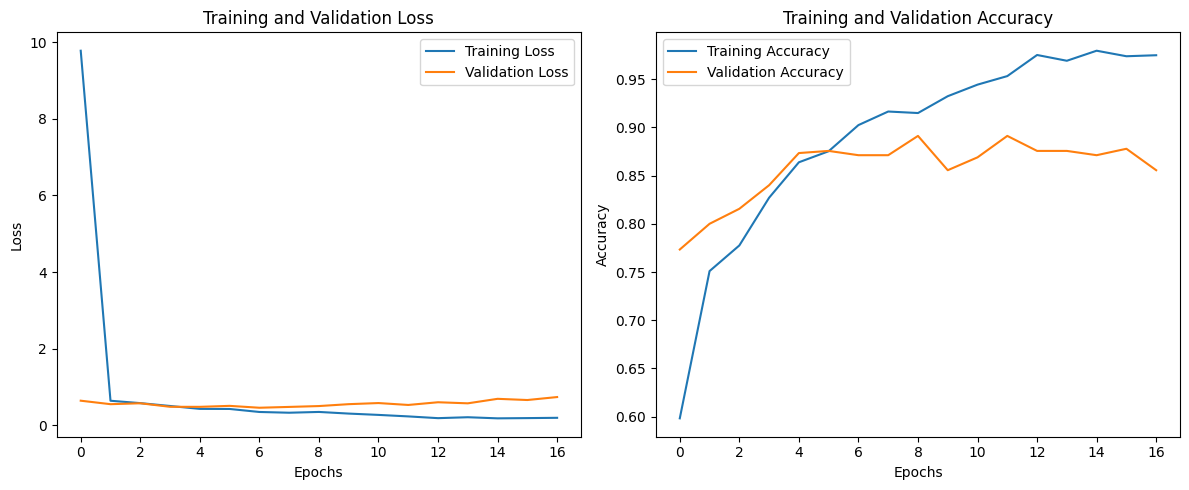

In [15]:
plot_history(history)